# PyTorch Test
## Chris Tralie

A simple test of torch in colab running logistic regression on two approximately linearly separable blobs

The first step is to install torch

In [1]:
!pip install torch


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from scipy import signal

# Torch Data Loader for 2D Blobs

In [3]:
class Blobs(Dataset):
    def __init__(self, n_samples, dim, offset):
        """
        Parameters
        ----------
        n_samples: int
            Number of samples to create per epoch
        dim: int
            Dimension of blobs
        offset: ndarray(dim)
            Offset of first blob with respect to the second one
        """
        self.n_samples = n_samples
        self.dim = dim
        self.offset = np.ones(dim)*offset
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        y = np.round(np.random.rand())
        x = np.random.randn(self.dim)
        if y == 1:
            x += self.offset
        x = torch.from_numpy(np.array(x, dtype=np.float32))
        y = torch.from_numpy(np.array(y, dtype=np.float32))
        return x, y

## Setup blobs dataset and solve logistic regression

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device", device)

n_samples = 1000
dim = 2
offset = 2
data = Blobs(n_samples, dim, 2)

perceptron = nn.Linear(dim, 1)
perceptron = perceptron.to(device)
optimizer = torch.optim.Adam(perceptron.parameters(), lr=1e-3)
loss_fn = torch.nn.BCEWithLogitsLoss()


n_epochs = 50
losses = []
accuracy = []
plt.figure(figsize=(12, 9))
for epoch in range(n_epochs):
    loader = DataLoader(data, batch_size=16, shuffle=True)
    for i, (inputs, labels) in enumerate(loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = perceptron(inputs)
        loss = loss_fn(outputs[:, 0], labels)
        loss.backward()
        optimizer.step()
        
    # Look at results on test set
    test_loader = DataLoader(data, batch_size=len(data))
    inputs, labels = next(iter(test_loader))
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = perceptron(inputs)
    total_loss = loss_fn(outputs[:, 0], labels)
    num_correct = torch.sum(0.5*(torch.sign(outputs[:, 0])+1) == labels)
    losses.append(total_loss.item())
    accuracy.append(num_correct.cpu()/len(data))

Device cpu


<Figure size 1200x900 with 0 Axes>

## Plot Optimization Progress

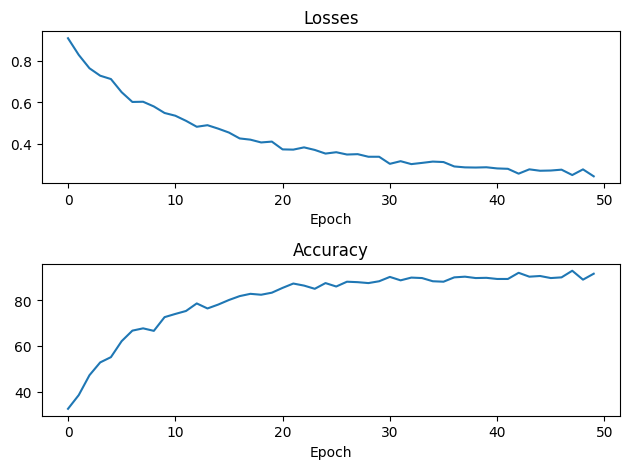

In [5]:
plt.figure()
plt.subplot(211)
plt.plot(losses)
plt.title("Losses")
plt.xlabel("Epoch")
plt.subplot(212)
plt.plot(np.array(accuracy)*100)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.tight_layout()

## Extract Parameters And Plot Some Results

0.83514535 1.1121314 -1.5473523


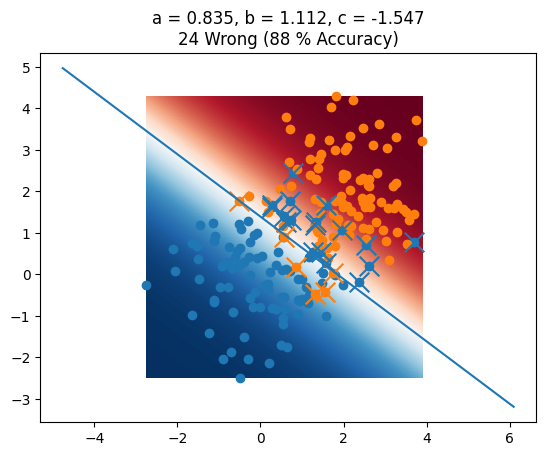

In [6]:
[ab, c] = list(perceptron.parameters())
ab = ab.detach().cpu().numpy().flatten()
a, b = ab
c = c.detach().cpu().numpy().flatten()[0]
print(a, b, c)


X0 = []
X1 = []
for i in range(200):
    x, y = data[i]
    x = x.detach().cpu().numpy()
    if y == 0:
        X0.append(x)
    else:
        X1.append(x)
X0 = np.array(X0)
X1 = np.array(X1)

logistic = lambda u: 1/(1 + np.exp(-u))


def plot_logistic_regression_predictions(X1, X2, a, b, c):
    plt.scatter(X1[:, 0], X1[:, 1])
    plt.scatter(X2[:, 0], X2[:, 1])
    X = np.concatenate((X1, X2), axis=0)
    xmin = np.min(X, axis=0)
    xmax = np.max(X, axis=0)
    iv = max(xmax[1]-xmin[1], xmax[0]-xmin[0])
    
    resol = 200
    mx = 2
    xx = np.linspace(xmin[0], xmax[0], resol)
    yy = np.linspace(xmin[1], xmax[1], resol)
    xx, yy = np.meshgrid(xx, yy)
    plt.imshow(logistic(a*xx+b*yy+c), extent=(xmin[0], xmax[0], xmax[1], xmin[1]), cmap='RdBu_r', vmin=0, vmax=1)
    
    
    p0 = -c*np.array([a, b])/(a**2 + b**2)
    v = np.array([-b, a])
    mag = np.sqrt(np.sum(v**2))
    if mag > 0:
        v = v/mag
        p = p0 - iv*v
        q = p0 + iv*v
        plt.plot([p[0], q[0]], [p[1], q[1]])
        rg = xmax[0] - xmin[0]
        plt.xlim([xmin[0]-0.2*rg, xmax[0]+0.2*rg])
        rg = xmax[1] - xmin[1]
        plt.ylim([xmin[1]-0.2*rg, xmax[1]+0.2*rg])

        wrong = 0
        for x in X1:
            y = logistic(a*x[0] + b*x[1] + c)
            proj = p0 + np.sum(v*(x-p0))*v
            #plt.plot([x[0], proj[0]], [x[1], proj[1]], c='C0')
            if y > 0.5:
                plt.scatter([x[0]], [x[1]], 200, c='C0', marker='x')
                wrong += 1
        for x in X2:
            y = logistic(a*x[0] + b*x[1] + c)
            proj = p0 + np.sum(v*(x-p0))*v
            #plt.plot([x[0], proj[0]], [x[1], proj[1]], c='C1')
            if y < 0.5:
                plt.scatter([x[0]], [x[1]], 200, c='C1', marker='x')
                wrong += 1
        N = X.shape[0]
        plt.title("a = {:.3f}, b = {:.3f}, c = {:.3f}\n{} Wrong ({} % Accuracy)".format(a, b, c, wrong, int(100*(N-wrong)/N)))
        plt.axis("equal")

plot_logistic_regression_predictions(X0, X1, a, b, c)